### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [11]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.000625
target_size = 256
epochs = 3

In [12]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [13]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [14]:
model = VGG16()

In [15]:
model.load_state_dict(torch.load("./model/MPFA_20.pth"), strict=False)

<All keys matched successfully>

In [16]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

In [18]:
for epoch in range(21, 24):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")
    torch.save(model.state_dict(),"./model/MPFA_{}.pth".format(epoch))

Epoch:22 loss:0.39263302087783813 Batch:100/2639 acc:0.917164146900177 pre:0.9323973059654236 recall:0.89371657371521 F-measure:0.92115718126297
Epoch:22 loss:0.3904310464859009 Batch:200/2639 acc:0.9221729636192322 pre:0.9365660548210144 recall:0.8948834538459778 F-measure:0.9248143434524536
Epoch:22 loss:0.3744924068450928 Batch:300/2639 acc:0.9219626188278198 pre:0.9344742298126221 recall:0.8930293917655945 F-measure:0.9228076338768005
Epoch:22 loss:0.3995867371559143 Batch:400/2639 acc:0.9232617616653442 pre:0.9326196312904358 recall:0.8907008767127991 F-measure:0.9205631017684937
Epoch:22 loss:0.3780486285686493 Batch:500/2639 acc:0.9235743880271912 pre:0.9346824288368225 recall:0.8904126286506653 F-measure:0.9219706654548645
Epoch:22 loss:0.38034334778785706 Batch:600/2639 acc:0.923301100730896 pre:0.936286211013794 recall:0.8938665986061096 F-measure:0.9241297841072083
Epoch:22 loss:0.39384669065475464 Batch:700/2639 acc:0.9236411452293396 pre:0.9368739724159241 recall:0.8924814

Epoch:24 loss:0.39232099056243896 Batch:100/2639 acc:0.9211422801017761 pre:0.934342086315155 recall:0.9050662517547607 F-measure:0.9259858727455139
Epoch:24 loss:0.38596227765083313 Batch:200/2639 acc:0.9241958260536194 pre:0.9372886419296265 recall:0.9000542759895325 F-measure:0.9266489744186401
Epoch:24 loss:0.38319647312164307 Batch:300/2639 acc:0.9248972535133362 pre:0.9361579418182373 recall:0.9002231955528259 F-measure:0.9257145524024963
Epoch:24 loss:0.37374651432037354 Batch:400/2639 acc:0.9245527982711792 pre:0.9368909001350403 recall:0.8982037901878357 F-measure:0.9258920550346375
Epoch:24 loss:0.3913346529006958 Batch:500/2639 acc:0.9246004819869995 pre:0.9390421509742737 recall:0.8971180319786072 F-measure:0.9271968603134155
Epoch:24 loss:0.39643996953964233 Batch:600/2639 acc:0.9240025281906128 pre:0.9372701048851013 recall:0.8971211910247803 F-measure:0.9258644580841064
Epoch:24 loss:0.3905346989631653 Batch:700/2639 acc:0.9237066507339478 pre:0.9371147751808167 recall:0

In [19]:
torch.save(model.state_dict(),"./model/MPFA_23.pth")

In [20]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [21]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [22]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [23]:
msk.shape

torch.Size([256, 256, 1])

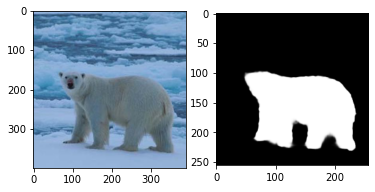

In [24]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

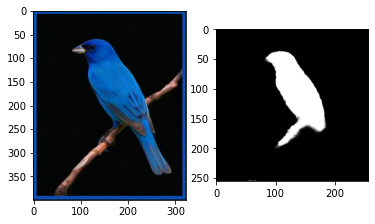

In [25]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

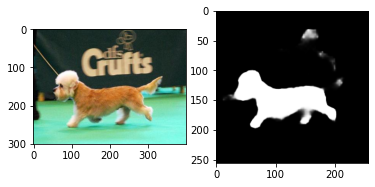

In [26]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()